# Regression and Curve Fitting

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from astropy.table import Table
import exoplanet as xo
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import seaborn as sns
import theano.tensor as T

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


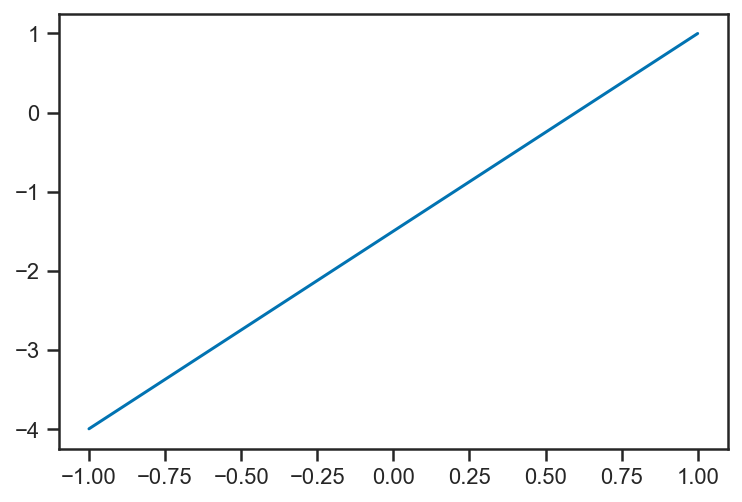

In [2]:
m_true = 2.5
b_true = -1.5

xs = linspace(-1, 1, 25)
ys_true = m_true*xs + b_true

plot(xs, ys_true)

<ErrorbarContainer object of 3 artists>

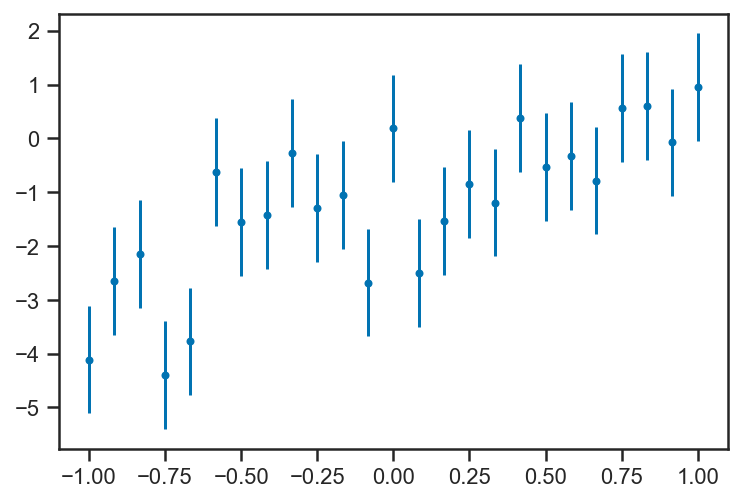

In [3]:
ys_obs = ys_true + randn(len(ys_true))
errorbar(xs, ys_obs, yerr=ones_like(ys_obs), fmt='.')

In [4]:
with pm.Model() as model:
    m = pm.Normal("m", 0, 4)
    b = pm.Normal("b", 0, 4)
    
    ys_true = pm.Deterministic("ys_true", m*xs + b)
    _ = pm.Normal("ys_obs", mu=ys_true, sigma=ones_like(ys_obs), observed=ys_obs)

In [5]:
with model:
    trace_linear = pm.sample()

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_84276/1043220295.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_linear = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'ys_true'}>,
        <AxesSubplot:title={'center':'ys_true'}>]], dtype=object)

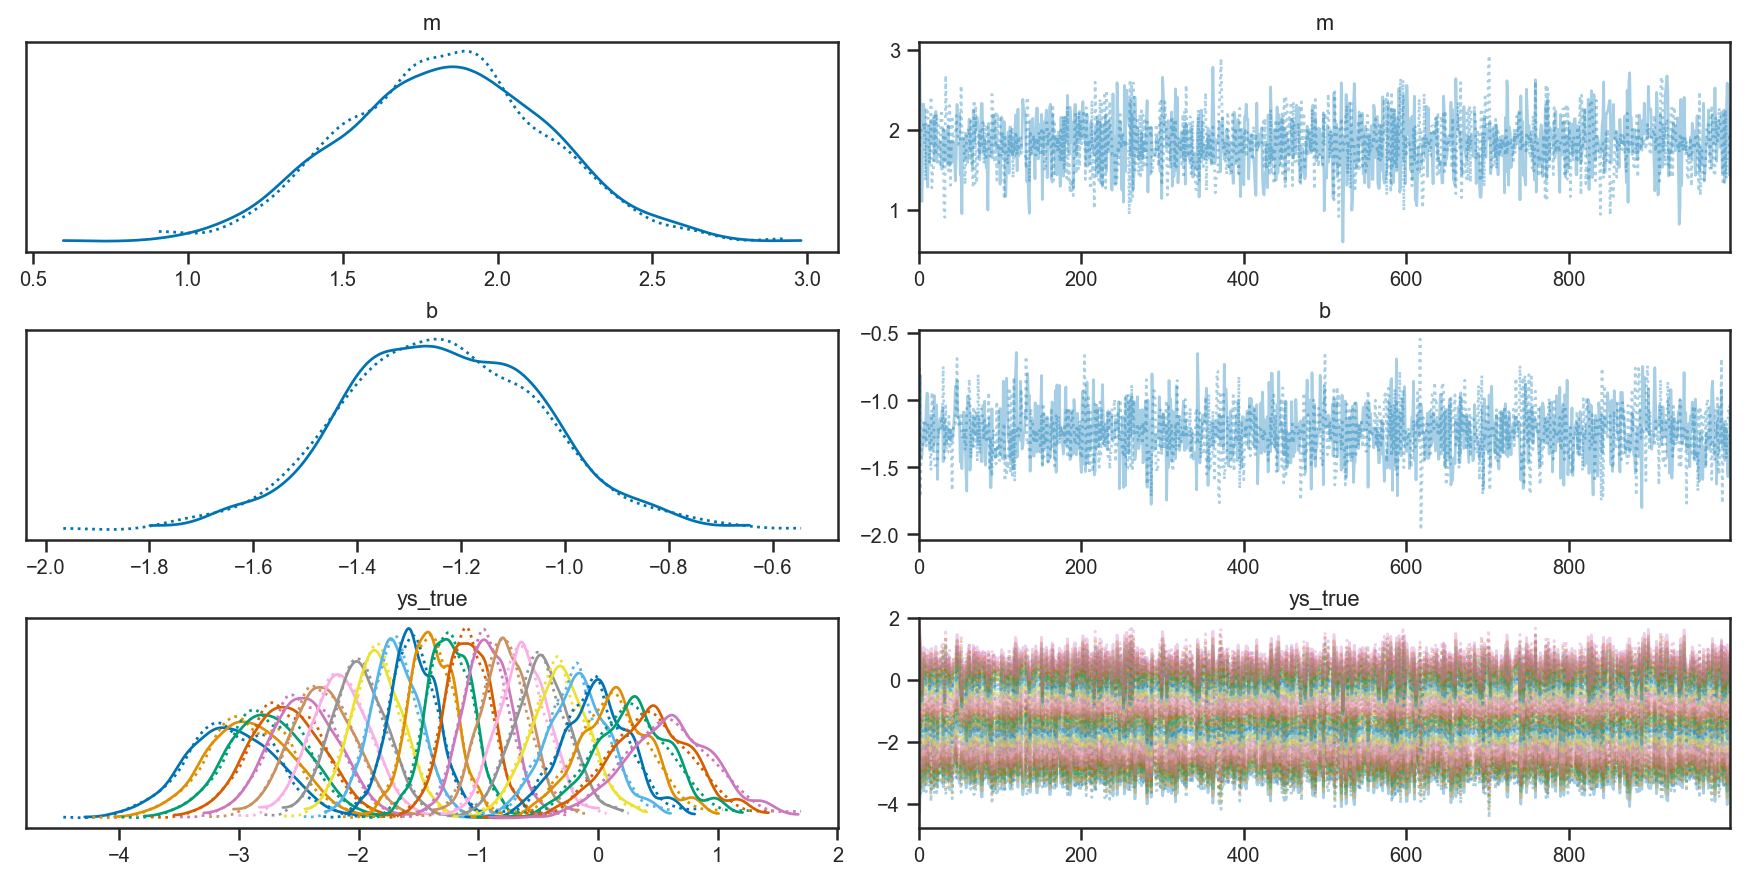

In [6]:
pm.plot_trace(trace_linear)

<ErrorbarContainer object of 3 artists>

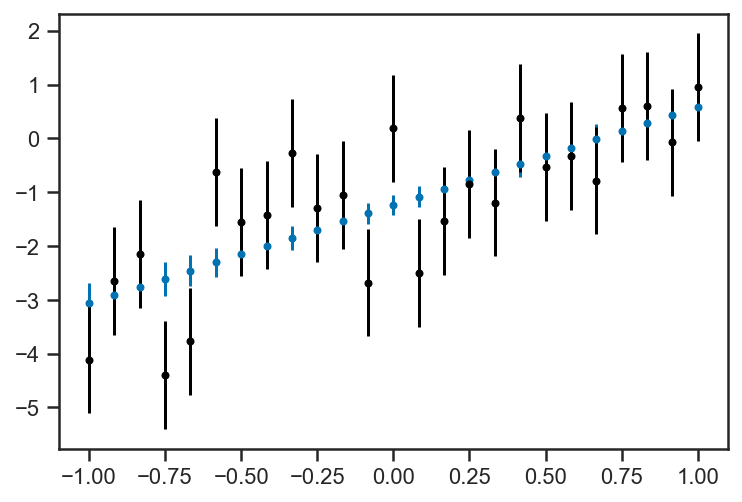

In [7]:
errorbar(xs, mean(trace_linear['ys_true'], axis=0), yerr=std(trace_linear['ys_true'], axis=0), fmt='.')
errorbar(xs, ys_obs, yerr=ones_like(ys_obs), color='black', fmt='.')

In [8]:
with pm.Model() as intrinsic_error_model:
    m = pm.Normal("m", mu=0, sigma=4)
    b = pm.Normal("b", mu=0, sigma=4)
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    dy_unit = pm.Normal("dy_unit", mu=0, sigma=1, shape=ys_obs.shape)
    ys_true = pm.Deterministic("ys_true", m*xs+b+sigma*dy_unit)
    
    _ = pm.Normal("ys_obs", mu=ys_true, sigma=1, observed=ys_obs)

In [9]:
with intrinsic_error_model:
    trace_intrinsic = pm.sample()

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_84276/2730893626.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_intrinsic = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dy_unit, sigma, b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'dy_unit'}>,
        <AxesSubplot:title={'center':'dy_unit'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'ys_true'}>,
        <AxesSubplot:title={'center':'ys_true'}>]], dtype=object)

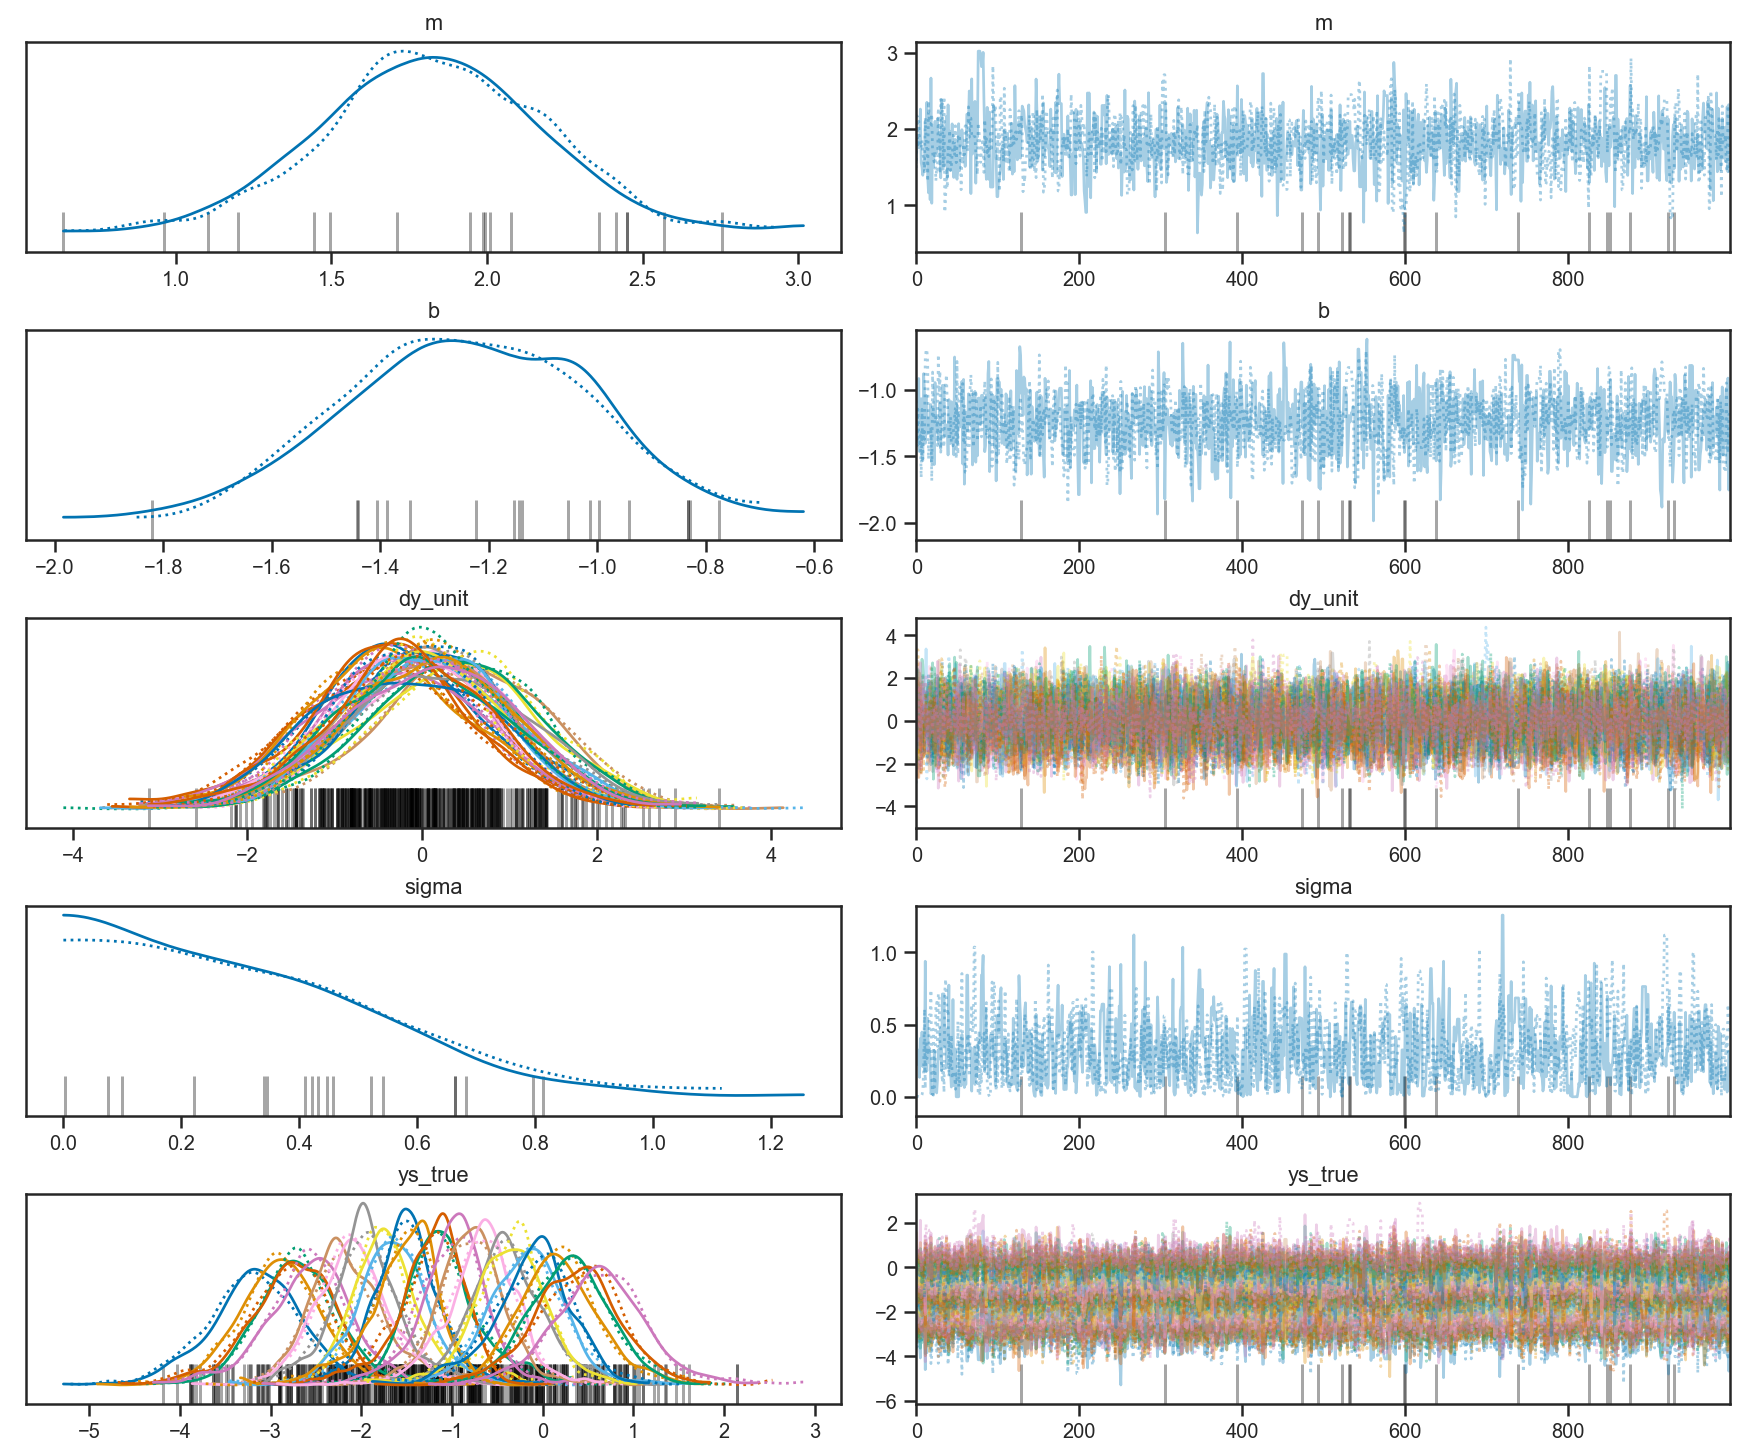

In [10]:
pm.plot_trace(trace_intrinsic)

<ErrorbarContainer object of 3 artists>

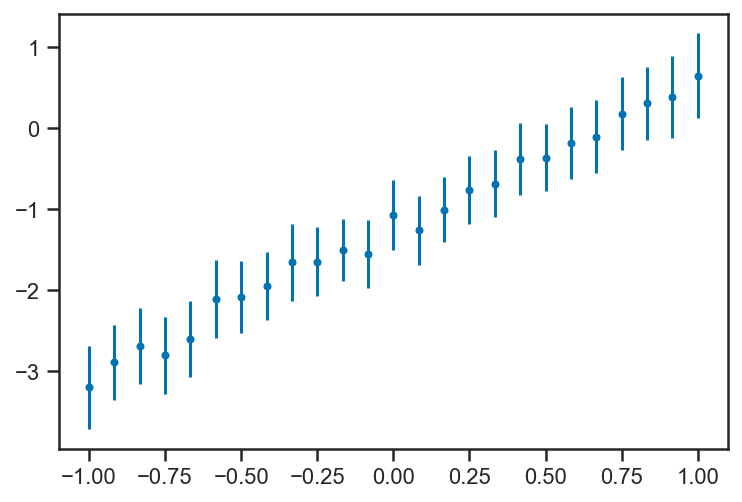

In [11]:
errorbar(xs, trace_intrinsic["ys_true"].mean(axis=0), yerr=trace_intrinsic["ys_true"].std(axis=0), fmt='.', label="Posterior")

<ErrorbarContainer object of 3 artists>

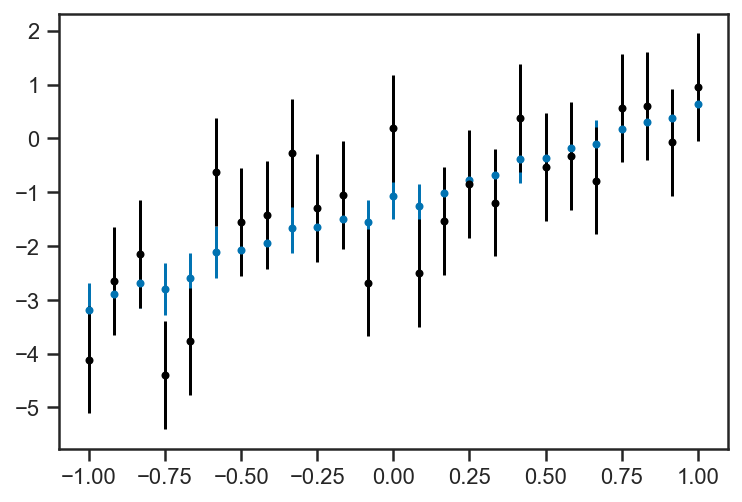

In [12]:
errorbar(xs, trace_intrinsic["ys_true"].mean(axis=0), yerr=trace_intrinsic["ys_true"].std(axis=0), fmt='.', label="Posterior")
errorbar(xs, ys_obs, yerr=ones_like(ys_obs), fmt='.', color="black", label="Observations")

51 Peg RV data, from [IPAC Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/51%20Peg%20b#overview).  These data are reported in {cite:t}`Butler2006`.

In [13]:
fopeg_data = Table.read('data/ButlerEtAl200651PegUID_0113357_RVC_001.tbl.txt', format='ascii')
fopeg_data

<Table length=256>
      JD       Radial_Velocity Radial_Velocity_Uncertainty
     days           m / s                 m / s           
   float64         float64               float64          
-------------- --------------- ---------------------------
2450002.665695           -52.9                         4.1
 2450002.68434           -45.8                         4.8
 2450002.80022           -60.8                         4.6
2450002.815961           -53.3                         5.0
2450002.954711           -60.9                         5.5
2450002.968287           -57.3                         7.0
           ...             ...                         ...
 2452173.74912           -52.7                         5.8
2452173.779745           -44.8                         5.9
2452184.745995            15.4                         5.5
2452184.776157             3.9                         5.5
2452189.678866           -37.8                         5.9
2452189.707882           -46.2                         6.0

This is the period reported by {cite:t}`Butler2006`:

In [14]:
P_fop = 4.230785 # (36) uncertainty in the last two digits!
sigma_P_fop = 0.000036

tmid = median(fopeg_data['JD'])

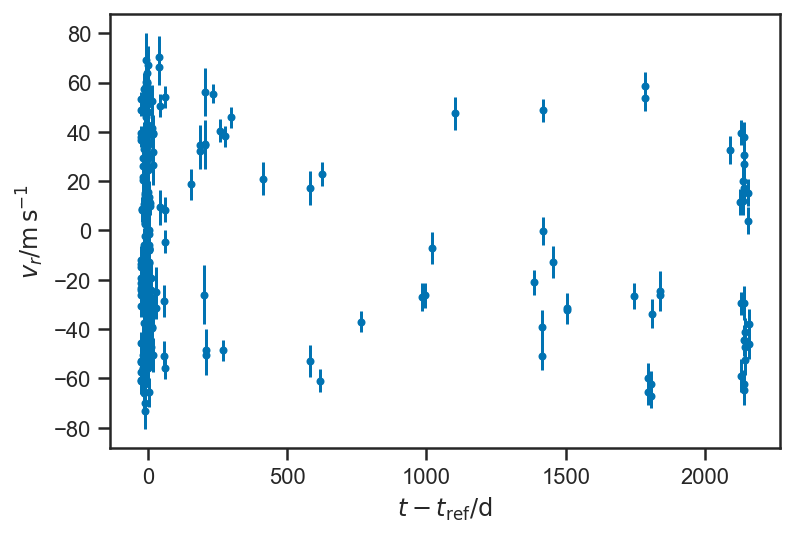

In [15]:
def plot_data(P=None, **kwargs):
    if P is None:
        ts = fopeg_data['JD'] - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{d}$')
    else:
        ts = (fopeg_data['JD'] - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{ref} \right) \, \mathrm{mod} \, P / \mathrm{d}$')
        
    errorbar(ts, fopeg_data['Radial_Velocity'], yerr=fopeg_data['Radial_Velocity_Uncertainty'], fmt='.', **kwargs)
    ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')
    
plot_data()

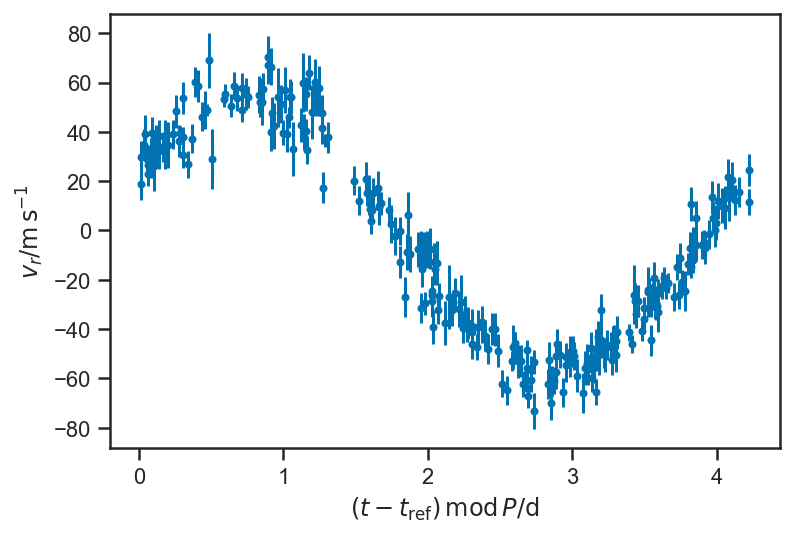

In [16]:
plot_data(P = P_fop)

Note Kepler's equations (e.g. {cite:t}`Fulton2018`):
$$
\frac{2 \pi \left( t - t_0 \right)}{P} = M = E - e \sin E
$$
with
$$
\nu = 2 \tan^{-1} \left( \sqrt{\frac{1+e}{1-e}} \tan \frac{E}{2} \right)
$$
and
$$
\dot{z} = v_r = K \left( \cos \left( \nu + \omega \right) + e \cos \omega \right),
$$
where 
* $t_0$ is the time of pericentre passage of the system.
* $P$ is the period.
* $e$ is the eccentricity.
* $E$ is the "eccentric anomaly".
* $\nu$ is the "true anomaly".
* $\omega$ is the argument of pericentre (of the star).
* $K$ is the semi-amplitude of the radial velocity (related to the planet and star masses and the inclination).

This formula relates something we measure "perfectly"---$t$, the time we measure the velocity---to something we measure with uncertainty, the radial velocity.  This is regression.

In [17]:
with pm.Model() as basic_rv:
    K = pm.Lognormal("K", mu=log(55.0), sigma=0.1)
    
    dP = pm.Normal("dP", mu=0, sigma=10)
    P = pm.Deterministic("P", P_fop + sigma_P_fop*dP)
    
    # Eccentricity vector:
    A = pmx.UnitDisk("A", testval=[0.01, 0.01])
    e = pm.Deterministic("e", T.sqrt(A[0]*A[0] + A[1]*A[1]))
    omega = pm.Deterministic("omega", T.arctan2(A[1], A[0]))
    
    t0_frac = pm.Uniform("t0_frac", 0, 1, testval=0.5)
    t0 = pm.Deterministic("t0", tmid + P*t0_frac)
    
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=e, omega=omega)
    
    rv = pm.Deterministic("v_r", orbit.get_radial_velocity(fopeg_data['JD'], K=K))
    
    _ = pm.Normal("v_r_obs", mu=rv, sigma=fopeg_data['Radial_Velocity_Uncertainty'], observed=fopeg_data['Radial_Velocity'])

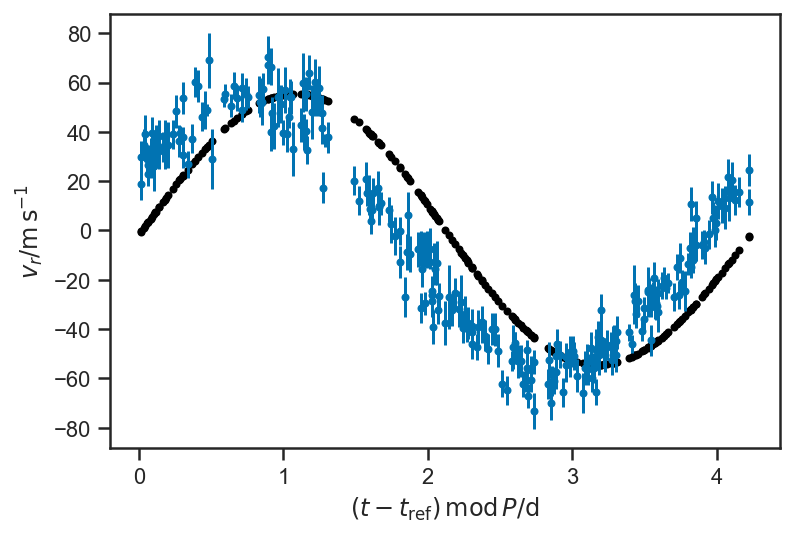

In [18]:
def plot_rv_curve(rvs, P=None, **kwargs):
    if P is None:
        ts = fopeg_data['JD'] - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{d}$')
    else:
        ts = (fopeg_data['JD'] - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{ref} \right) \, \mathrm{mod} \, P / \mathrm{d}$')

    marker = kwargs.pop('marker', '.')
    scatter(ts, rvs, marker=marker, **kwargs)
plot_data(P=P_fop)
plot_rv_curve(pmx.eval_in_model(rv, basic_rv.test_point, model=basic_rv), P=P_fop, color='black')

In [19]:
with basic_rv:
    map_soln = pmx.optimize(start=model.test_point, vars=[t0_frac])
    map_soln = pmx.optimize(start=map_soln, vars=[t0_frac, dP])
    map_soln = pmx.optimize(start=map_soln, vars=[t0_frac, dP, K, A])

optimizing logp for variables: [t0_frac]


message: Optimization terminated successfully.
logp: -2244.1075127125005 -> -895.194386147021
optimizing logp for variables: [dP, t0_frac]


message: Desired error not necessarily achieved due to precision loss.
logp: -895.194386147021 -> -892.0967029641428
optimizing logp for variables: [A, K, dP, t0_frac]


message: Optimization terminated successfully.
logp: -892.0967029641428 -> -889.7860524910117


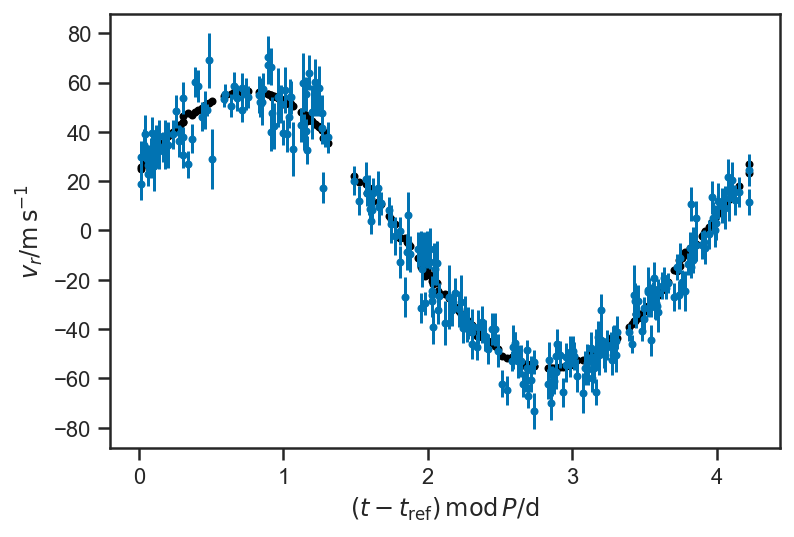

In [20]:
plot_data(P=P_fop)
plot_rv_curve(pmx.eval_in_model(rv, map_soln, model=basic_rv), P=P_fop, color='black')

In [21]:
with basic_rv:
    basic_rv_trace = pm.sample(tune=1000, draws=1000)

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_84276/3110477701.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  basic_rv_trace = pm.sample(tune=1000, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0_frac, A, dP, K]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.


/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: Runt

array([[<AxesSubplot:title={'center':'dP'}>,
        <AxesSubplot:title={'center':'dP'}>],
       [<AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'t0_frac'}>,
        <AxesSubplot:title={'center':'t0_frac'}>],
       [<AxesSubplot:title={'center':'t0'}>,
        <AxesSubplot:title={'center':'t0'}>],
       [<AxesSubplot:title={'center':'v_r'}>,
        <AxesSubplot:title={'center':'v_r'}>]], dtype=object)

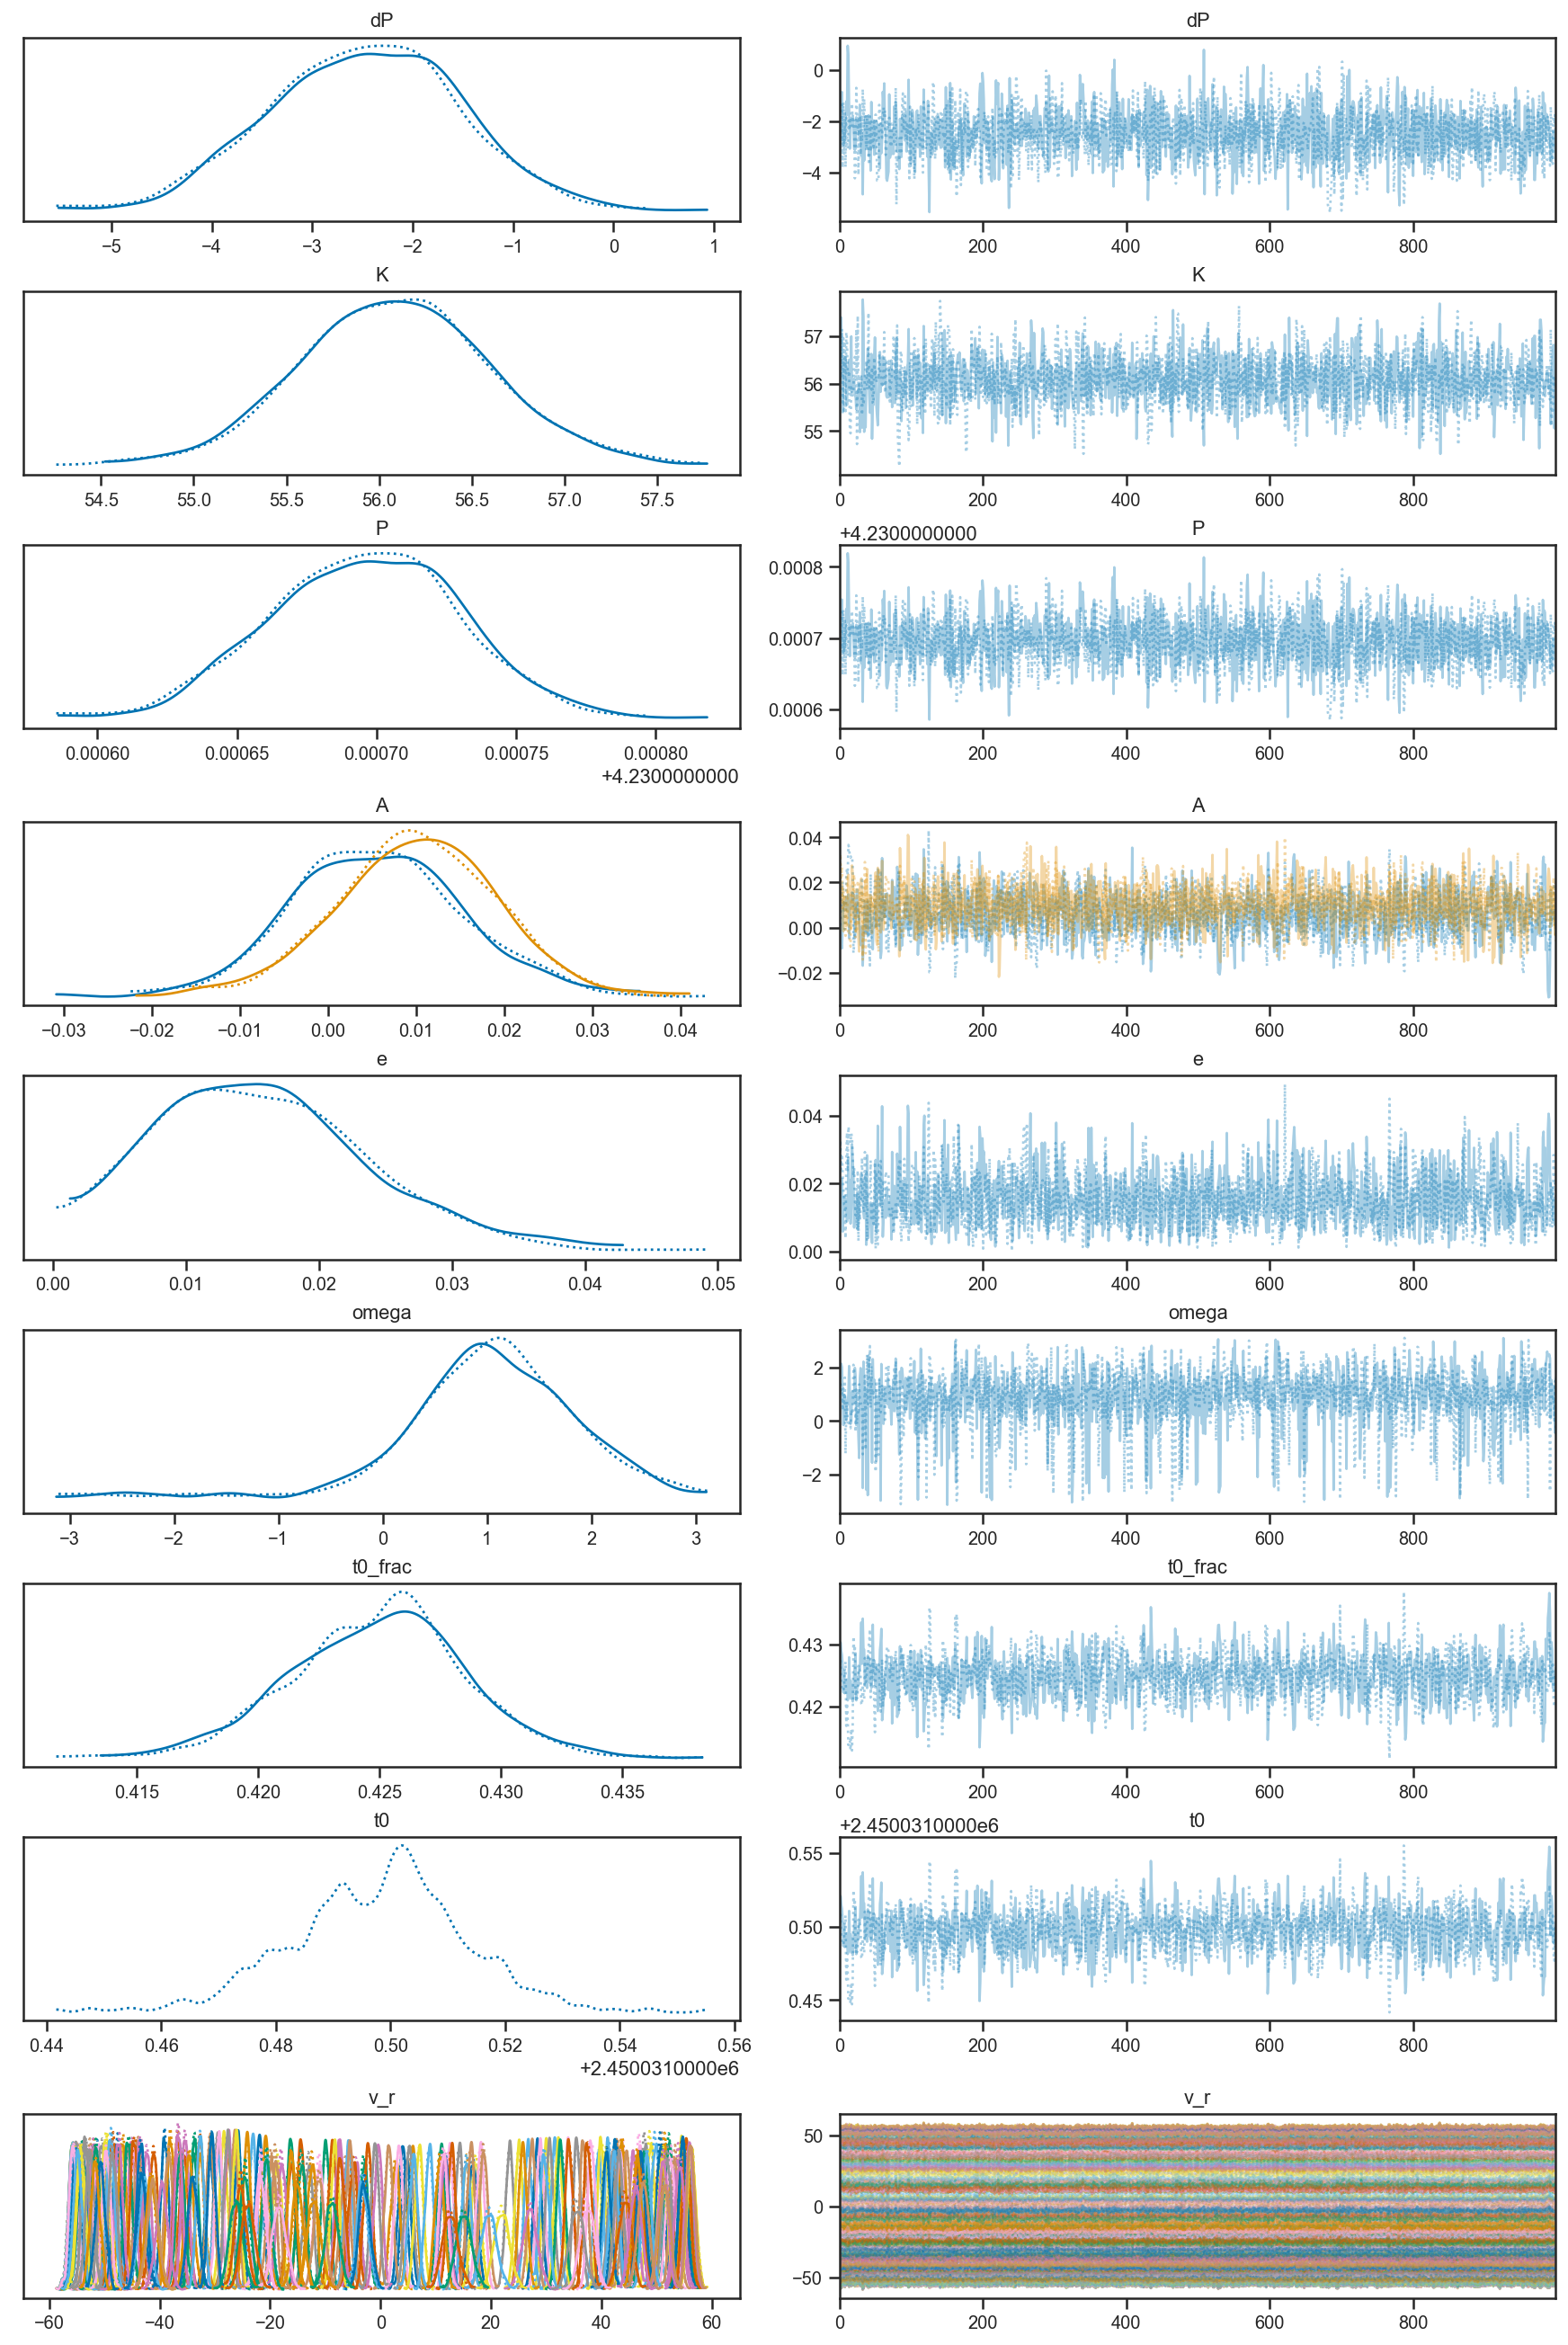

In [22]:
pm.plot_trace(basic_rv_trace)

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='P'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='e'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='omega'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='K', ylabel='t0'>, <AxesSubplot:xlabel='P'>,
        <AxesSubplot:xlabel='e'>, <AxesSubplot:xlabel='omega'>]],
      dtype=object)

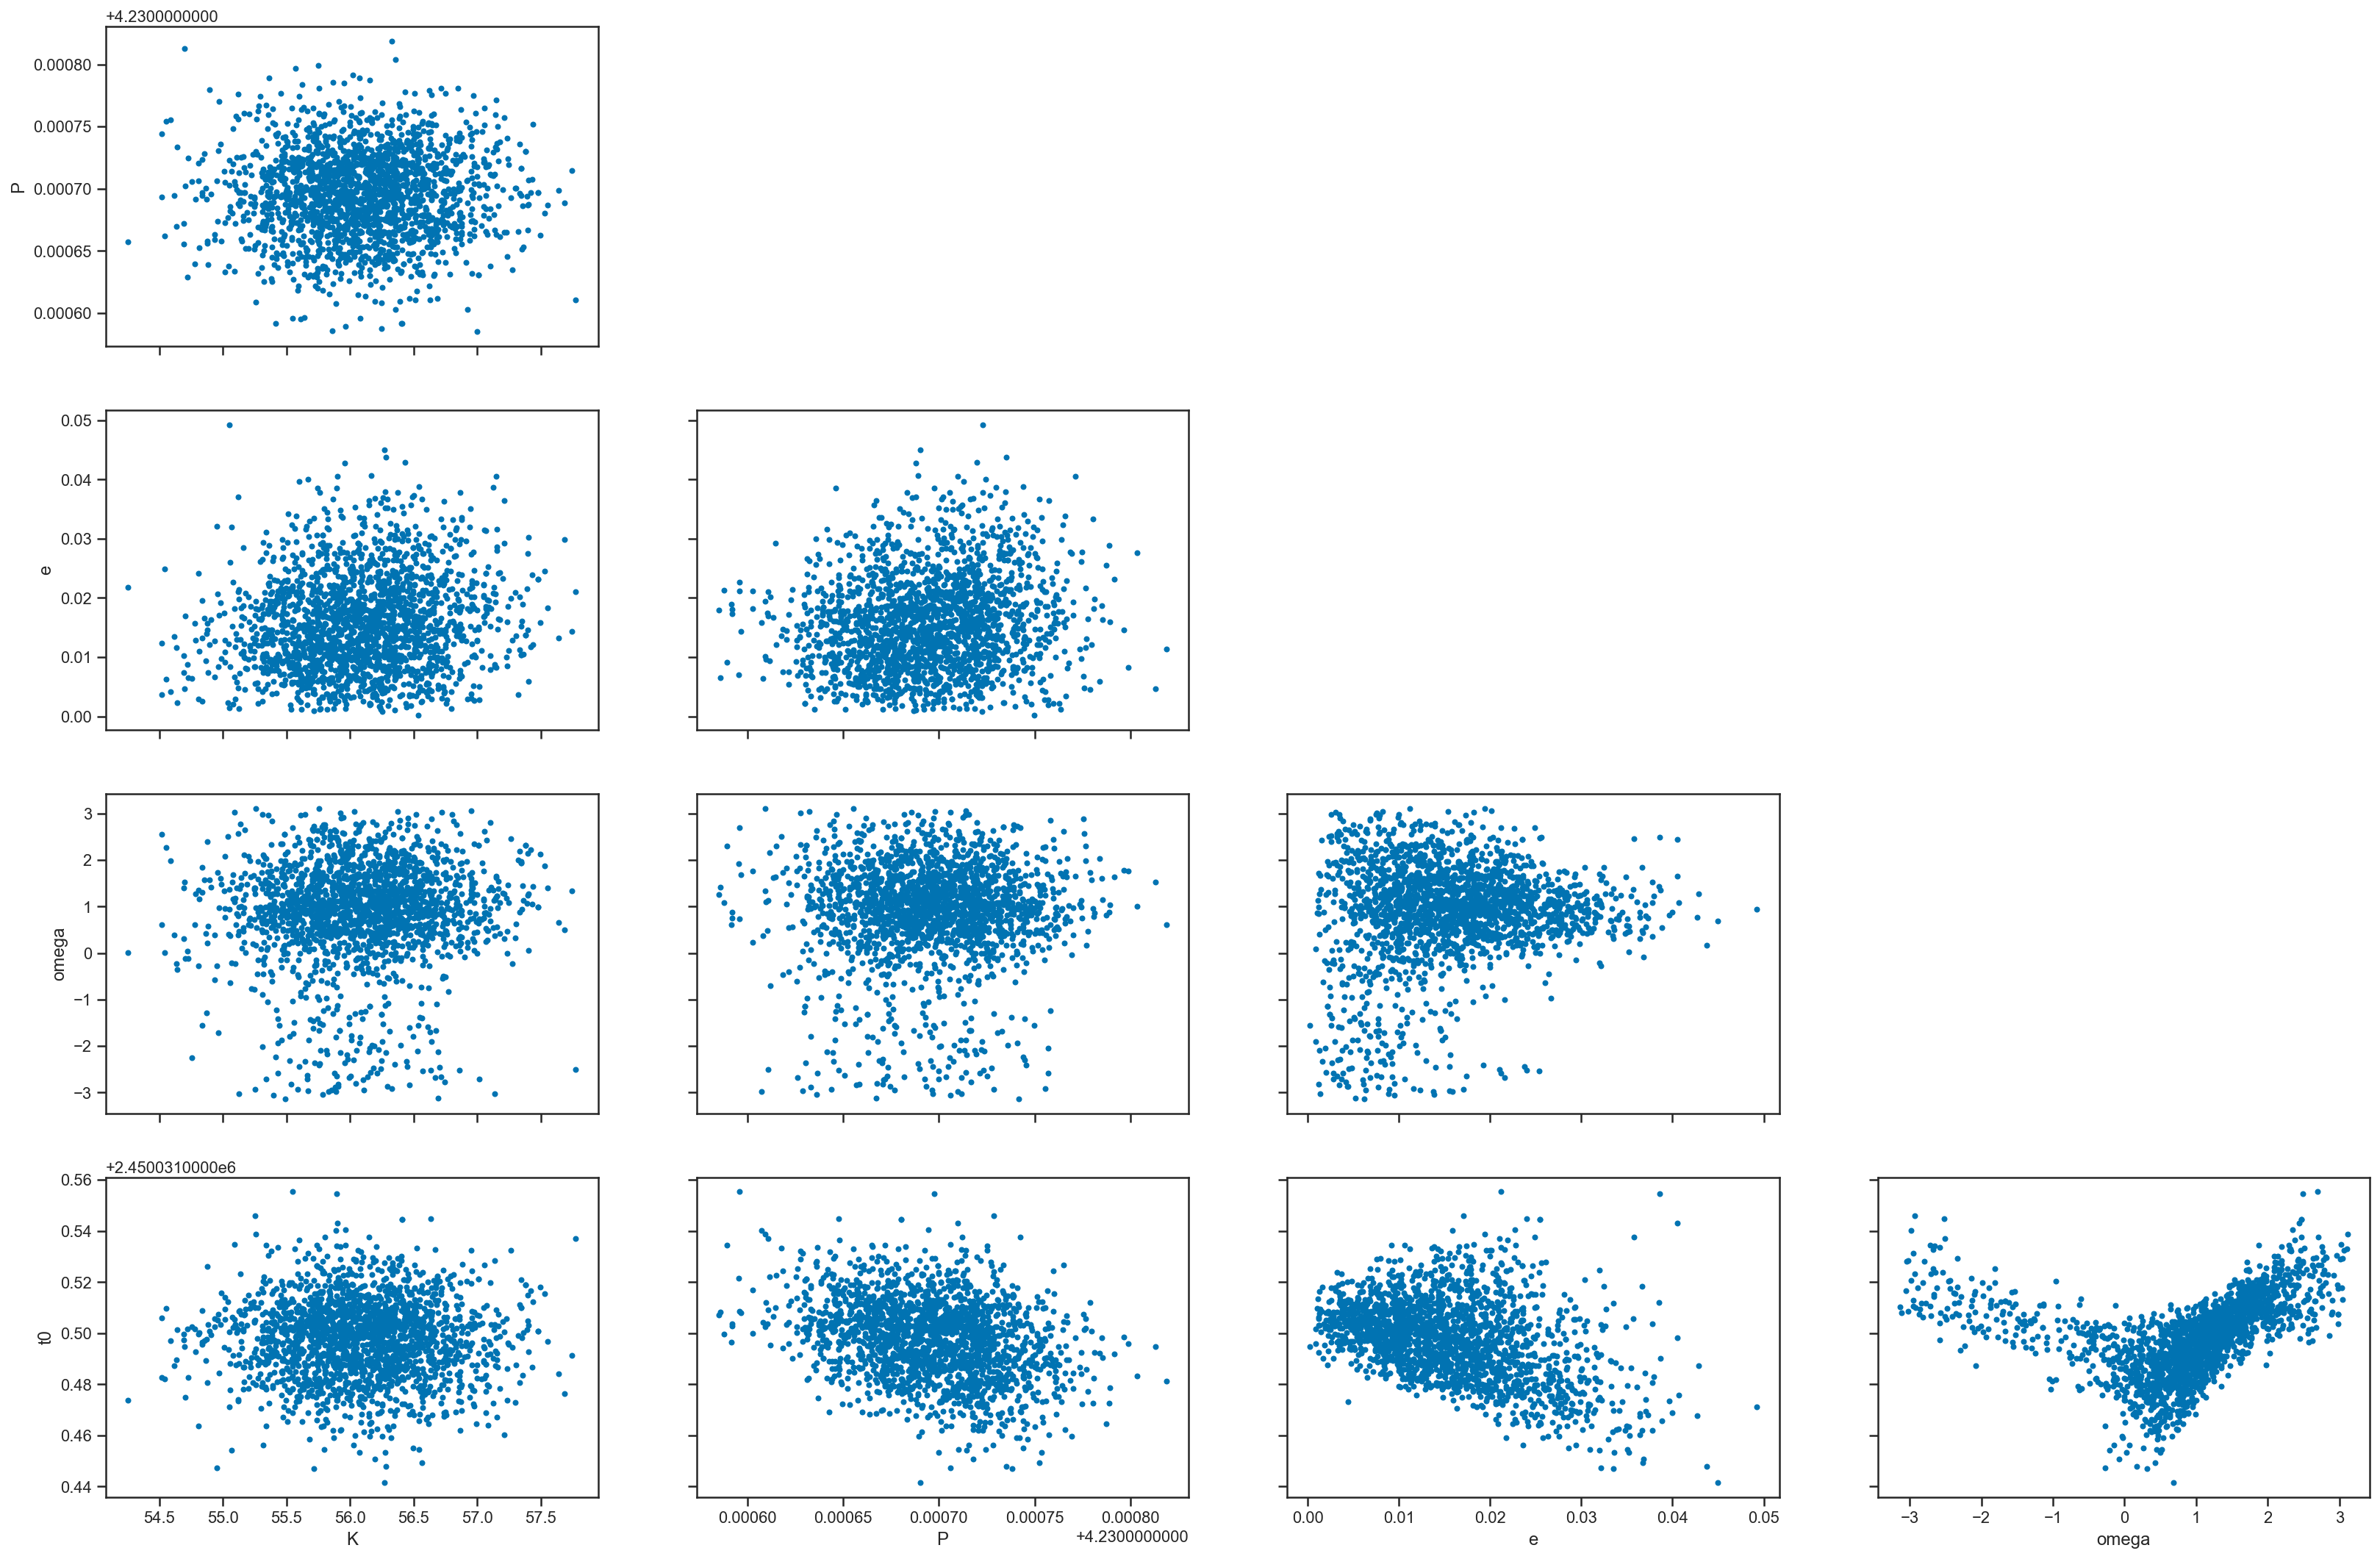

In [23]:
pm.plot_pair(basic_rv_trace, var_names=['K', 'P', 'e', 'omega', 't0'])

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'P'}>]], dtype=object)

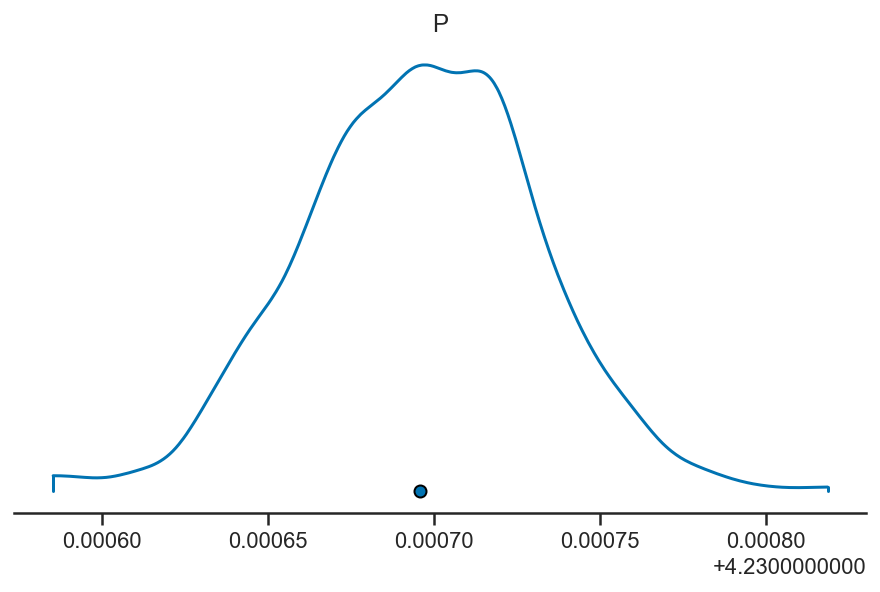

In [24]:
pm.plot_density(basic_rv_trace, var_names=['P'], hdi_prob=1)

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'e'}>]], dtype=object)

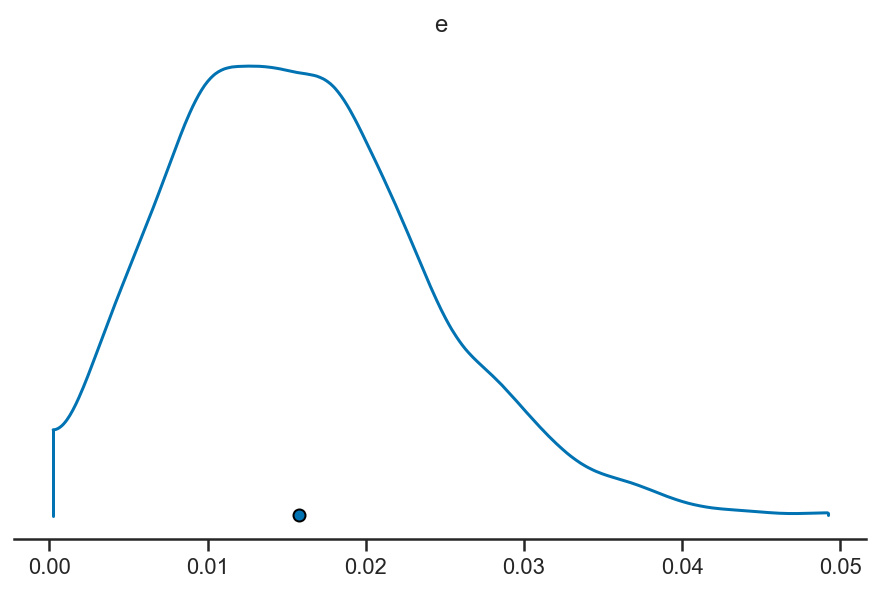

In [25]:
pm.plot_density(basic_rv_trace, var_names=['e'], hdi_prob=1)

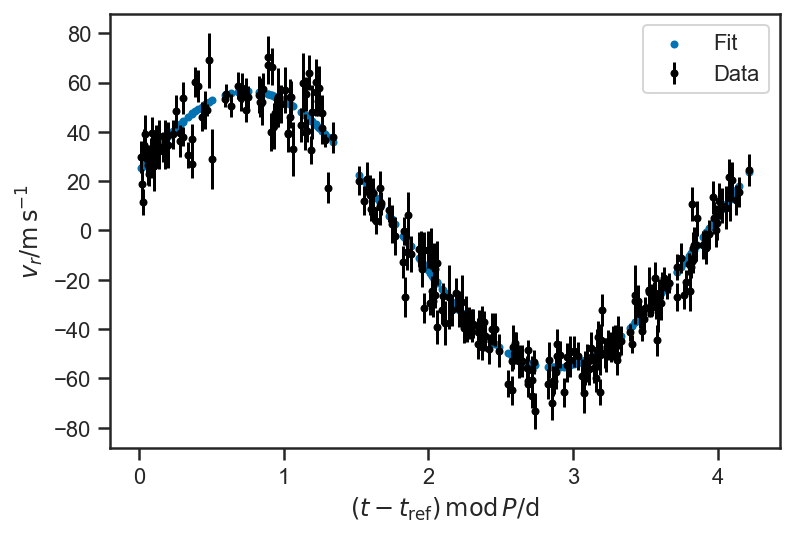

In [26]:
N = basic_rv_trace['P'].shape[0]
i = randint(0, N)
P = basic_rv_trace['P'][i]
plot_data(P = P, color='black', label='Data')
plot_rv_curve(basic_rv_trace['v_r'][i,:], P = P, label='Fit')
legend(loc='best')

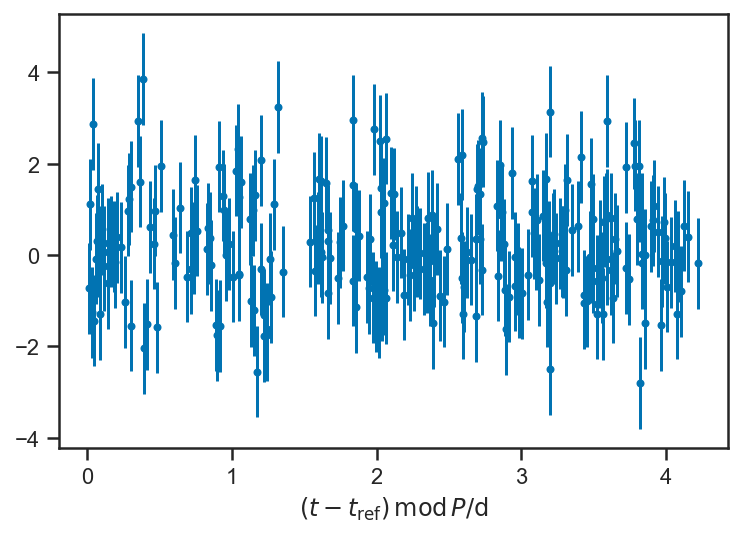

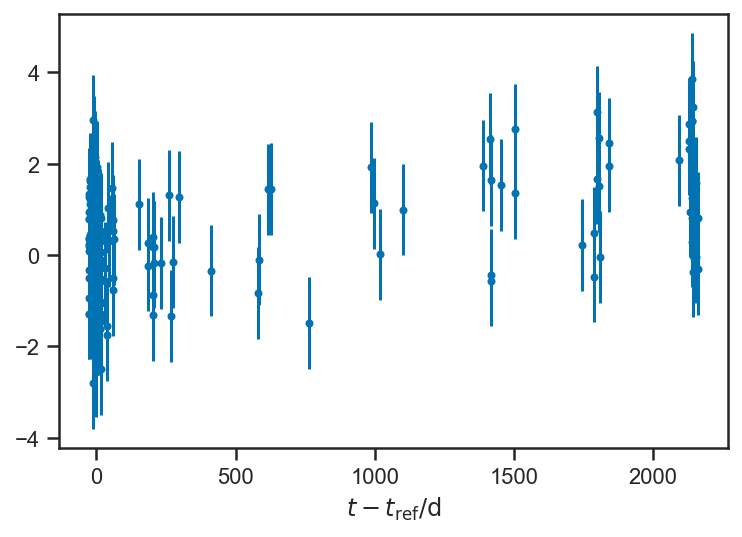

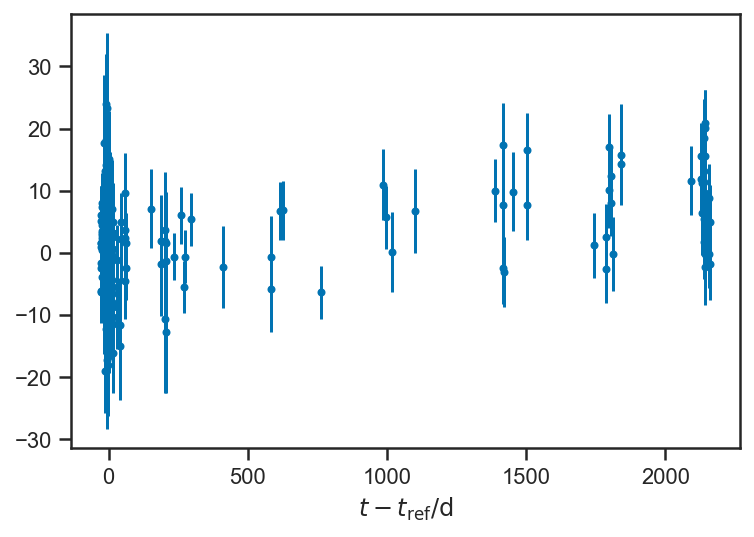

In [33]:
def plot_residuals(rvs, P=None, normalize=True, **kwargs):
    if P is None:
        ts = fopeg_data['JD'] - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{d}$')
    else:
        ts = (fopeg_data['JD'] - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{ref} \right) \, \mathrm{mod} \, P / \mathrm{d}$')

    r = rvs - fopeg_data['Radial_Velocity']
    if normalize:
        r = r / fopeg_data['Radial_Velocity_Uncertainty']
        sigma_r = ones_like(r)
    else:
        sigma_r = fopeg_data['Radial_Velocity_Uncertainty']
        
    fmt = kwargs.pop('fmt', '.')
    errorbar(ts, r, yerr=sigma_r, fmt=fmt, **kwargs)
plot_residuals(mean(basic_rv_trace['v_r'], axis=0), P = mean(basic_rv_trace['P']))
figure()
plot_residuals(mean(basic_rv_trace['v_r'], axis=0))
figure()
plot_residuals(mean(basic_rv_trace['v_r'], axis=0), normalize=False)

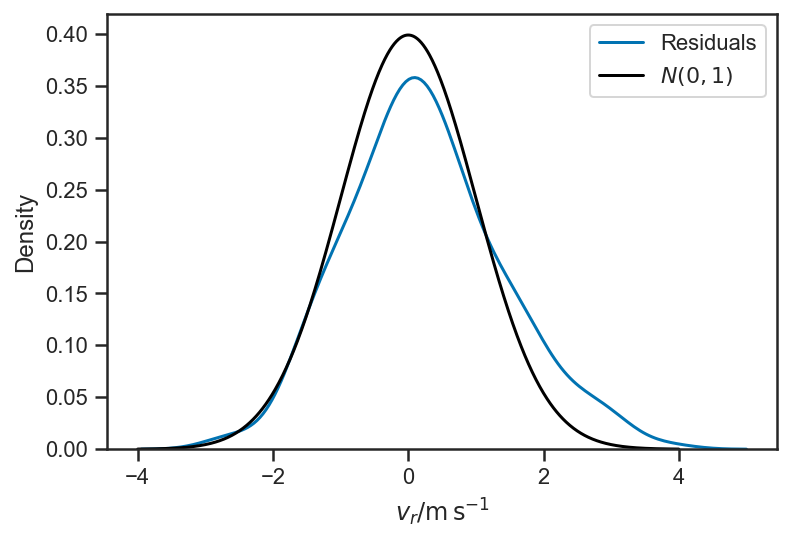

In [32]:
sns.kdeplot((mean(basic_rv_trace['v_r'], axis=0) - fopeg_data['Radial_Velocity'])/fopeg_data['Radial_Velocity_Uncertainty'], label='Residuals')
xlabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')
xs = linspace(-4, 4, 1024)
plot(xs, 1/sqrt(2*pi)*exp(-0.5*xs*xs), color='black', label='$N(0,1)$')
legend(loc='best')